In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


cpu_files = [
    "azure_data/processed_data/sql_elastic_pools_cpu_utilization.csv",
    "azure_data/processed_data/vm_scale_sets_cpu_utilization.csv",
    "azure_data/processed_data/vms_cpu_utilization.csv"
]

memory_files = [
    "azure_data/processed_data/sql_elastic_pools_memory_utilization.csv",
    "azure_data/processed_data/vm_scale_sets_memory_utilization.csv",
    "azure_data/processed_data/vms_memory_utilization.csv"
]

def load_utilization_data(files, metric_type):
    """Loads and combines utilization data from multiple files."""
    dfs = []
    for file in files:
        df = pd.read_csv(file)
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%d/%m/%Y %H:%M")
        df["Source"] = file.split("/")[-1].replace("_utilization.csv", "")
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

cpu_data = load_utilization_data(cpu_files, "CPU Utilization")
memory_data = load_utilization_data(memory_files, "Memory Utilization")

def plot_utilization(df, metric):
    plt.figure(figsize=(12, 6))

    for source in df["Source"].unique():
        subset = df[df["Source"] == source]

        numeric_data = subset.iloc[:, 1:-1].apply(pd.to_numeric, errors='coerce')

        subset_downsampled = subset.iloc[::10, :]
        numeric_data_downsampled = numeric_data.iloc[::10, :]

        mean_values = numeric_data_downsampled.mean(axis=1)

        plt.plot(subset_downsampled["Timestamp"], mean_values, label=source)

    plt.xlabel("Time")
    plt.ylabel(f"{metric} (%)")
    plt.legend()
    
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout() 
    
    plt.show()



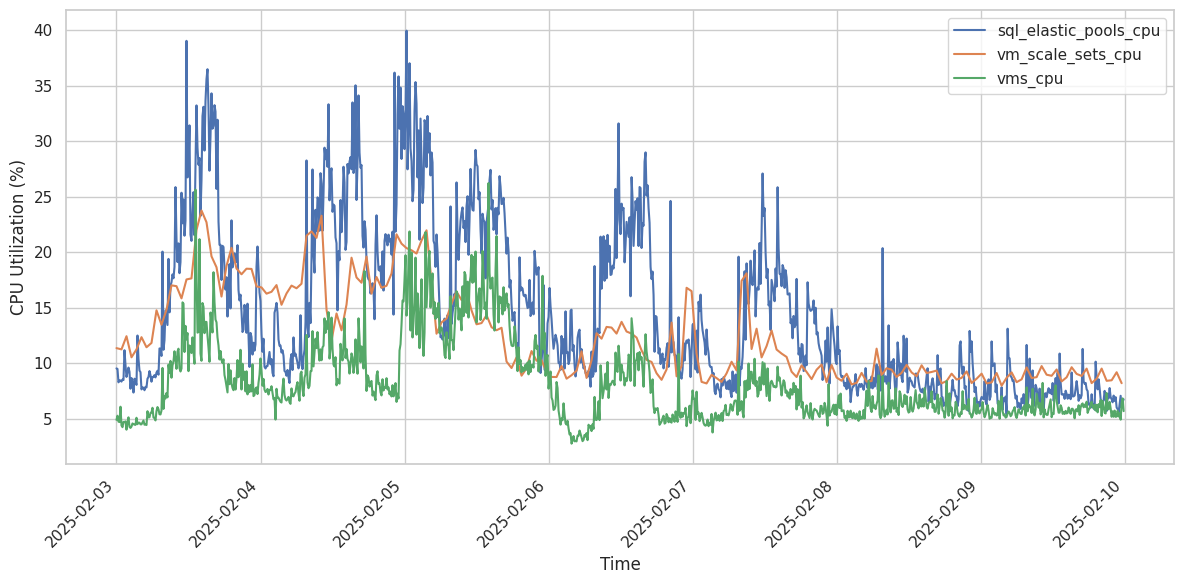

In [6]:
plot_utilization(cpu_data, "CPU Utilization")

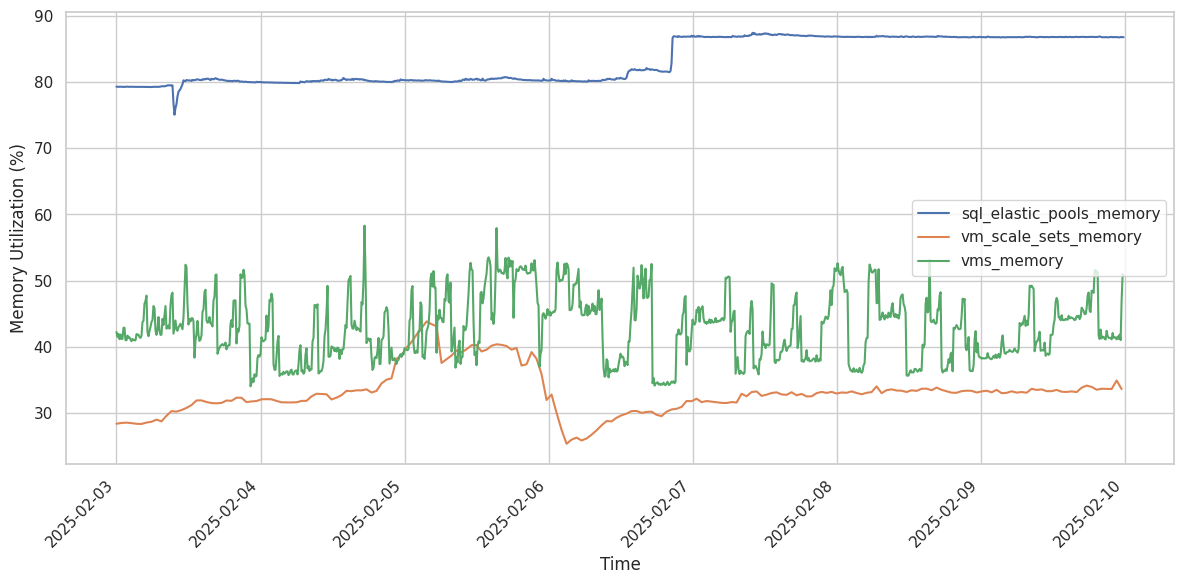

In [7]:
plot_utilization(memory_data, "Memory Utilization")

In [8]:
cpu_summary = cpu_data.iloc[:, 1:-1].describe()
memory_summary = memory_data.iloc[:, 1:-1].describe()

print("### CPU Utilization Summary:")
print(cpu_summary)
print("\n### Memory Utilization Summary:")
print(memory_summary)


### CPU Utilization Summary:
       NEXTTENANTPOOL001  SERVER002POOL004  SERVER002POOL001  \
count       10080.000000      10080.000000      10080.000000   
mean           22.812116         20.236244         19.947973   
std            17.972391         12.431065         14.220117   
min             2.259259          4.763889          3.629630   
25%             9.180556         10.833333         10.458333   
50%            17.229167         17.333333         15.173611   
75%            30.392361         25.545139         24.545139   
max            96.518519         93.972222         95.648148   

       SERVER002POOL003  SERVER002POOL002  NEXTTENANTPOOL002  \
count      10080.000000      10080.000000       10080.000000   
mean          19.907427         19.671715          18.945558   
std           13.933732         13.453586          13.260217   
min            3.888889          3.222222           3.138889   
25%           10.805556         10.069444           9.803241   
50%       